French Fake News Detection baseline model 

This notebook contains : 
- Preparation input data TF-IDF
- Training baseline Sequence Classification (using "LogisticRegression")
- Evaluation

Works on Google Colab


## Import

In [1]:
%matplotlib inline

# for figure
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

# for training
#from simpletransformers.classification import ClassificationModel

# to save 
import pickle
from sklearn.externals import joblib

# useful
import pandas as pd
import numpy as np
import numpy.ma as ma
import shutil
import os
import re
import math

# for text manipulation
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from collections import defaultdict
from nltk.stem.snowball import FrenchStemmer
#from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# for model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
# import user module
#from my_text_utils import myTokenizer

import platform

# for cross validation
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Definitions

In [8]:
# your data folder
PATH_FOLDER_SAVE = '../../data'
# your code folder 
PATH_FOLDER_CODE = \
  "/content/drive/My Drive/OpenClassRooms/IML_Projet_7/code/FakeNewsDetectionFr"
# % of data used for training
train_percent = 0.7

# path folder saved model
PATH_FOLDER_MODEL_SAVED = '/content/drive/My Drive/outputs_proj7'


# path to save df news
PATH_DF_NEWS_SAVE = PATH_FOLDER_SAVE + '/df_news.pkl' 
# path to save df news cleaned
path_save_df_news_clean = PATH_FOLDER_SAVE + "/df_news_clean.pkl" 

# SPECIAL EXPORT DATA WITH CODE
PATH_FOLDER_EXPORT = "data"
# path to  export file CSV into code/data folder of df news
PATH_DF_NEWS_EXPORT = PATH_FOLDER_EXPORT + '/df_news.csv' 

# path to save count
path_save_count_vect = PATH_FOLDER_SAVE + "/count_vect.pkl"
# path to save tfidf
path_save_tfidf_transformer = PATH_FOLDER_SAVE + "/tfidf_transformer.pkl"
# path to save model log reg
path_save_clf_log_reg = PATH_FOLDER_SAVE + "/clf_log_reg.pkl"
# save df results
PATH_DF_RES_SAVE = PATH_FOLDER_SAVE + '/df_res.pkl'

RANDOM_STATE = 0

# get computer name
COMPUTERNAME = platform.node()

# check if Google colab need Drive ?
if re.match("^/content", os.getcwd()):
    print("GOOGLE COLAB MODE")
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    os.chdir(PATH_FOLDER_CODE)


GOOGLE COLAB MODE
Mounted at /content/drive


## Useful functions

In [0]:
# prepare dictionnary of translation to suppress ponctuation
replace_punctuation = str.maketrans(string.punctuation,
                                    ' '*len(string.punctuation))
def cleaning_text(questions_curr):
    '''
    Clean text : delete ponctuation, quotes, html tags, lowercase, tokenize
    '''
    #cleaning_text("<a> dede<a/> l'aube est arrivée : “war horse” chien")
    # delete newlines
    questions_curr = re.sub(r'\s+', ' ', questions_curr)
    # delete single quotes
    questions_curr = re.sub(r"\'", " ", questions_curr)
    # delete double quotes
    questions_curr = re.sub(r'\"', " ", questions_curr)
    # delete tags
    questions_curr = re.sub('<[^<]+?>',' ', questions_curr)
    # delete numbers (forming group = word with only numbers 
    # example : delete "123" but not "a123")
    questions_curr = re.sub(r'\b\d+\b','', questions_curr) 
    # delete ponctuation (replace by space)
    questions_curr = questions_curr.translate(replace_punctuation)
    # keep only word
    questions_curr = re.sub(r'\W',  ' ', questions_curr)
    # lower case
    questions_curr = ' '.join([w.lower() for w in \
                               nltk.word_tokenize(questions_curr,
                                                  language='french') \
                              if not w.lower() in list(sw)])

    return questions_curr

def myTokenizer(text):
    '''
    Create tokens from text (French words > 3 letters)
    '''
    def stem_tokens(tokens, stemmer):
        '''
        Stem words in tokens.
        and suppress word < 3 characters
        '''
        stemmed = []
        for item in tokens:
            if re.match('[a-zA-Z0-9]{3,}',item):
                stemmed.append(stemmer.stem(item))
        return stemmed

    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, FrenchStemmer())
    return stems

def plot_confusion_matrix(y_true, y_pred, classes, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, size=16, fontsize=12, 
                          threshold=None):
    """
    V2.0 : 18/01/2019 : G.LANG : correction nan value for color
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    source : 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]

    # extract most important confusion if threshold
    if threshold is not None:
      list_idx=[]
      for i in range(0, cm.shape[0]):
        for j in range(0, cm.shape[1]):
          if i != j:
            if cm[i,j] > threshold:
              list_idx.append(i)
              list_idx.append(j)
      list_idx = np.unique(list_idx)
      cm = cm[np.ix_(list_idx, list_idx)]
      classes = classes[list_idx]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
 
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", fontsize=fontsize)
    # resize y tick labels
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    mask_test = ma.masked_invalid(cm)
    thresh = mask_test.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=fontsize,
                    fontweight="black" if i==j else "normal")
    fig.tight_layout()

    fig.set_size_inches([size,size])
    ax.set_ylim([cm.shape[1]-0.5,-0.5]);
    ax.grid(linewidth=0)
    return ax

## Prepare Data 

### Load data

In [0]:
df_news = joblib.load(PATH_DF_NEWS_SAVE)

In [0]:
df_news.head()

,url,source,author,title,theme,description,date_published,body,fake,text,train,nb_words,fake_pred,fp,fn
1,https://www.liberation.fr/france/2019/12/15/le...,Liberation,Nathalie Raulin,Les chefs de service hospitaliers en appellent...,france,Jugeant très insuffisante la réponse du gouver...,15/12/2019,C’est une menace d’une démission collective qu...,0,Les chefs de service hospitaliers en appellent...,False,789,0,False,False
2,https://www.futura-sciences.com/sante/actualit...,Futura Sciences,Futura avec Relaxnews,L'origine des comportements alimentaires ident...,sante,D'après une étude publiée dans la revue,16/12/2019,D'après une étude publiée dans la revue Natur...,0,L'origine des comportements alimentaires ident...,True,499,0,False,False
3,https://www.futura-sciences.com/tech/actualite...,Futura Sciences,Louis Neveu,Microsoft alerte sur de nouvelles techniques d...,tech,Le géant de l'informatique Microsoft vient de ...,16/12/2019,Le géant de l'informatique Microsoft vient de ...,0,Microsoft alerte sur de nouvelles techniques d...,True,412,0,False,False
4,https://www.futura-sciences.com/sciences/actua...,Futura Sciences,Rémy Decourt,L'Europe se dote d'une infrastructure de téléc...,sciences,Pour garantir la sécurité de la libre circulat...,16/12/2019,Pour garantir la sécurité de la libre circulat...,0,L'Europe se dote d'une infrastructure de téléc...,False,1269,0,False,False
6,https://www.futura-sciences.com/sciences/actua...,Futura Sciences,Nathalie Mayer,Science décalée : la créature la plus rapide s...,sciences,Le guépard est l'animal le plus rapide... sur ...,15/12/2019,Le guépard est l'animal le plus rapide... sur ...,0,Science décalée : la créature la plus rapide s...,True,557,0,False,False


In [0]:
df_news.shape

(2432, 15)

### Features




In [0]:
news = df_news.filter(items=["text"]).to_dict()
news = news["text"]

### Stopwords

In [0]:
tokenizer = nltk.RegexpTokenizer(r'\w+')

def freq_stats_corpora(my_corpus):
    '''
    Statistics about words in my_corpus
    '''
    corpora = defaultdict(list)

    # Création d'un corpus de tokens par question
    for id_curr,text_curr in my_corpus.items():        
        try:
            corpora[id_curr] += tokenizer.tokenize(text_curr.lower())
        except:
            print('text_curr {} : Error body empty'.format(id_curr))
            
    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
        
    return (freq, stats, corpora)

# Récupération des comptages
freq, stats, corpora = freq_stats_corpora(news)
#df_stats = pd.DataFrame.from_dict(stats, orient='index')



# Premièrement, on récupère la fréquence totale de chaque mot sur tout le corpus
# de questions
freq_totale = nltk.Counter()
for k, v in news.items():
    freq_totale += freq[k]



In [0]:
freq_totale.most_common(100)

[('de', 60954),
 ('la', 34250),
 ('le', 25787),
 ('l', 24083),
 ('à', 23543),
 ('les', 22745),
 ('des', 20230),
 ('et', 20130),
 ('d', 18655),
 ('en', 17778),
 ('un', 15777),
 ('une', 13251),
 ('a', 12921),
 ('est', 12864),
 ('du', 12003),
 ('pour', 11426),
 ('dans', 10094),
 ('il', 9972),
 ('que', 9310),
 ('qui', 9205),
 ('sur', 7776),
 ('par', 7239),
 ('pas', 6921),
 ('au', 6807),
 ('plus', 6348),
 ('ce', 6313),
 ('qu', 5351),
 ('s', 4885),
 ('ne', 4563),
 ('n', 4551),
 ('on', 4528),
 ('se', 4506),
 ('c', 4281),
 ('avec', 4242),
 ('son', 4195),
 ('ont', 3990),
 ('mais', 3742),
 ('sont', 3652),
 ('islam', 3490),
 ('cette', 3108),
 ('ou', 3104),
 ('été', 3006),
 ('nous', 2961),
 ('aux', 2853),
 ('comme', 2715),
 ('sa', 2582),
 ('elle', 2568),
 ('je', 2507),
 ('vous', 2373),
 ('y', 2363),
 ('aussi', 2339),
 ('ces', 2332),
 ('même', 2296),
 ('être', 2254),
 ('tout', 2207),
 ('leur', 2164),
 ('fait', 2140),
 ('ils', 2093),
 ('ses', 2071),
 ('deux', 1930),
 ('après', 1840),
 ('depuis', 183

In [0]:
# Stopwords : 100 first most used words + typical french stopwords
most_freq = freq_totale.most_common(100)
sw = set()
for tuple_freq in most_freq:
    sw.add(tuple_freq[0])
    
sw.update(tuple(nltk.corpus.stopwords.words('french')))
sw

{'a',
 'ai',
 'aie',
 'aient',
 'aies',
 'ainsi',
 'ait',
 'alors',
 'ans',
 'après',
 'as',
 'au',
 'aura',
 'aurai',
 'auraient',
 'aurais',
 'aurait',
 'auras',
 'aurez',
 'auriez',
 'aurions',
 'aurons',
 'auront',
 'aussi',
 'autres',
 'aux',
 'avaient',
 'avais',
 'avait',
 'avant',
 'avec',
 'avez',
 'aviez',
 'avions',
 'avoir',
 'avons',
 'ayant',
 'ayante',
 'ayantes',
 'ayants',
 'ayez',
 'ayons',
 'bien',
 'c',
 'ce',
 'ces',
 'cette',
 'comme',
 'contre',
 'd',
 'dans',
 'de',
 'depuis',
 'des',
 'deux',
 'dont',
 'du',
 'déjà',
 'elle',
 'en',
 'encore',
 'entre',
 'es',
 'est',
 'et',
 'eu',
 'eue',
 'eues',
 'eurent',
 'eus',
 'eusse',
 'eussent',
 'eusses',
 'eussiez',
 'eussions',
 'eut',
 'eux',
 'eûmes',
 'eût',
 'eûtes',
 'faire',
 'fait',
 'fois',
 'france',
 'français',
 'furent',
 'fus',
 'fusse',
 'fussent',
 'fusses',
 'fussiez',
 'fussions',
 'fut',
 'fûmes',
 'fût',
 'fûtes',
 'gouvernement',
 'il',
 'ils',
 'islam',
 'j',
 'je',
 'jour',
 'l',
 'la',
 'le',

In [0]:
# save stopwords
path_save_sw = PATH_FOLDER_SAVE + "/stop_words_sw.pkl"
joblib.dump(sw, path_save_sw)
print("Stop words Saved here:\n{}".format(path_save_sw))


Stop words Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_7/data/stop_words_sw.pkl


### Clean Text

In [0]:
clean_text_dict = dict()
# for each news, prepare token : lower, no ponctuation
for id_curr, news_curr in news.items():
    try:
        # save cleaned text into dict output
        clean_text_dict[id_curr] = cleaning_text(news_curr) 
    except:
        print('News {} : Error body empty'.format(id_curr))

In [0]:
df_clean = pd.DataFrame.from_dict(clean_text_dict, orient='index', 
                                  columns=["clean_text"])
df_clean.head()

,clean_text
1,chefs service hospitaliers appellent démission...
2,origine comportements alimentaires identifiée ...
3,microsoft alerte nouvelles techniques phishing...
4,europe dote infrastructure télécommunications ...
6,science décalée créature rapide terre celle cr...


In [0]:
df_news_clean = df_news.copy()
df_news_clean["clean_text"] = df_clean["clean_text"]
df_news_clean.head()

,url,source,author,title,theme,description,date_published,body,fake,text,train,nb_words,fake_pred,fp,fn,clean_text
1,https://www.liberation.fr/france/2019/12/15/le...,Liberation,Nathalie Raulin,Les chefs de service hospitaliers en appellent...,france,Jugeant très insuffisante la réponse du gouver...,15/12/2019,C’est une menace d’une démission collective qu...,0,Les chefs de service hospitaliers en appellent...,False,789,0,False,False,chefs service hospitaliers appellent démission...
2,https://www.futura-sciences.com/sante/actualit...,Futura Sciences,Futura avec Relaxnews,L'origine des comportements alimentaires ident...,sante,D'après une étude publiée dans la revue,16/12/2019,D'après une étude publiée dans la revue Natur...,0,L'origine des comportements alimentaires ident...,True,499,0,False,False,origine comportements alimentaires identifiée ...
3,https://www.futura-sciences.com/tech/actualite...,Futura Sciences,Louis Neveu,Microsoft alerte sur de nouvelles techniques d...,tech,Le géant de l'informatique Microsoft vient de ...,16/12/2019,Le géant de l'informatique Microsoft vient de ...,0,Microsoft alerte sur de nouvelles techniques d...,True,412,0,False,False,microsoft alerte nouvelles techniques phishing...
4,https://www.futura-sciences.com/sciences/actua...,Futura Sciences,Rémy Decourt,L'Europe se dote d'une infrastructure de téléc...,sciences,Pour garantir la sécurité de la libre circulat...,16/12/2019,Pour garantir la sécurité de la libre circulat...,0,L'Europe se dote d'une infrastructure de téléc...,False,1269,0,False,False,europe dote infrastructure télécommunications ...
6,https://www.futura-sciences.com/sciences/actua...,Futura Sciences,Nathalie Mayer,Science décalée : la créature la plus rapide s...,sciences,Le guépard est l'animal le plus rapide... sur ...,15/12/2019,Le guépard est l'animal le plus rapide... sur ...,0,Science décalée : la créature la plus rapide s...,True,557,0,False,False,science décalée créature rapide terre celle cr...


In [0]:
# save clean text
path_save_df_news_clean = PATH_FOLDER_SAVE + "/df_news_clean.pkl"
joblib.dump(df_news_clean, path_save_df_news_clean)
print("df news clean Saved here:\n{}".format(path_save_df_news_clean))

df news clean Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_7/data/df_news_clean.pkl


### Count words

In [0]:
# init features
tf_vectorizer = CountVectorizer(max_df=0.11, min_df=10, max_features=10000,
                                      tokenizer=myTokenizer)

# train counts
X_train_counts = tf_vectorizer.\
    fit_transform(df_news_clean[\
                                   df_news_clean["train"]\
                                   == True]["clean_text"])

X_train_counts.shape

(1703, 3411)

In [0]:
# save CountVectorizer
path_save_count_vect = PATH_FOLDER_SAVE + "/count_vect.pkl"
joblib.dump(tf_vectorizer, path_save_count_vect)
print("tf_vectorizer Saved here:\n{}".format(path_save_count_vect))

tf_vectorizer Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_7/data/count_vect.pkl


In [0]:
# test counts
X_test_counts = tf_vectorizer.transform(
    df_news_clean[df_news_clean["train"] == False]["clean_text"])
X_test_counts.shape

(729, 3411)

### TF-IDF

In [0]:
# calculate tf-idf
tfidf_transformer = TfidfTransformer().fit(X_train_counts)
# train
X_train_tfidf = tfidf_transformer.transform(X_train_counts)

print("X_train_tfidf.shape" , X_train_tfidf.shape)
# test
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print("X_test_tfidf.shape" , X_test_tfidf.shape)

X_train_tfidf.shape (1703, 3411)
X_test_tfidf.shape (729, 3411)


In [0]:
# save TfidfTransformer
path_save_tfidf_transformer = PATH_FOLDER_SAVE + "/tfidf_transformer.pkl"
joblib.dump(tfidf_transformer, path_save_tfidf_transformer)
print("tfidf_transformer Saved here:\n{}".format(path_save_tfidf_transformer))

tfidf_transformer Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_7/data/tfidf_transformer.pkl


# Baseline : LogisticRegression




### Train model

In [0]:
clf_log_reg = LogisticRegression(random_state=RANDOM_STATE)

clf_log_reg.fit(X_train_tfidf, 
              df_news_clean[df_news_clean["train"] == True]["fake"])
print("Train Score : ",
      clf_log_reg.score(X_train_tfidf, 
                      df_news_clean[df_news_clean["train"] == True]["fake"]))
print("Test Score : ",
      clf_log_reg.score(X_test_tfidf, 
                      df_news_clean[df_news_clean["train"] == False]["fake"]))

Train Score :  0.9782736347621844
Test Score :  0.9012345679012346


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
# save clf_log_reg
joblib.dump(clf_log_reg, path_save_clf_log_reg)
print("clf_log_reg Saved here:\n{}".format(path_save_clf_log_reg))

clf_log_reg Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_7/data/clf_log_reg.pkl


### Load model & data pretreated

In [9]:
# load clean text
df_news_clean = joblib.load(path_save_df_news_clean)
print("df news clean loaded from:\n{}".format(path_save_df_news_clean))

# load CountVectorizer
tf_vectorizer = joblib.load(path_save_count_vect)
print("tf_vectorizer loaded from:\n{}".format(path_save_count_vect))

# load TfidfTransformer
tfidf_transformer = joblib.load(path_save_tfidf_transformer)
print("tfidf_transformer loaded from:\n{}".format(path_save_tfidf_transformer))

# load model
clf_log_reg = joblib.load(path_save_clf_log_reg)

df news clean loaded from:
../../data/df_news_clean.pkl


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


tf_vectorizer loaded from:
../../data/count_vect.pkl


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


tfidf_transformer loaded from:
../../data/tfidf_transformer.pkl


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### Eval

In [0]:
y_train_pred = clf_log_reg.predict(X_train_tfidf)
y_test_pred = clf_log_reg.predict(X_test_tfidf)
print("acc score Train : ", 
      accuracy_score(df_news_clean[df_news_clean["train"] == True]["fake"], 
                     y_train_pred))
print("acc score Test : ", 
      accuracy_score(df_news_clean[df_news_clean["train"] == False]["fake"], 
                     y_test_pred))

# add to news dataFrame
df_news["fake_pred_logreg"] = 0
df_news.loc[df_news["train"] == True, "fake_pred_logreg"] = y_train_pred
df_news.loc[df_news["train"] == False, "fake_pred_logreg"] = y_test_pred
# save results into dataFrame
joblib.dump(df_news, PATH_DF_NEWS_SAVE)

acc score Train :  0.9782736347621844
acc score Test :  0.9012345679012346


['/content/drive/My Drive/OpenClassRooms/IML_Projet_7/data/df_news.pkl']

### Load model & data

In [10]:
X_train_counts = tf_vectorizer.transform(
    df_news_clean[df_news_clean["train"] == True]["clean_text"])
X_train_tfidf = tfidf_transformer.transform(X_train_counts)

X_test_counts = tf_vectorizer.transform(
    df_news_clean[df_news_clean["train"] == False]["clean_text"])
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

y_train_pred = clf_log_reg.predict(X_train_tfidf)
y_test_pred = clf_log_reg.predict(X_test_tfidf)

acc_train = accuracy_score(
    df_news_clean[df_news_clean["train"] == True]["fake"], y_train_pred)
print("acc score Train : ", acc_train)

acc_test = accuracy_score(
    df_news_clean[df_news_clean["train"] == False]["fake"], y_test_pred)
print("acc score Test : ", acc_test)

acc score Train :  0.9782736347621844
acc score Test :  0.9012345679012346


In [16]:
df_res = pd.DataFrame(index=["RegLog"], 
                      columns=["acc_train", "acc_test", 
                               "mean_acc_splits_test", "error_margin"], 
                      data=np.array([[acc_train, acc_test, np.nan, np.nan
                                      ]]))
df_res

,acc_train,acc_test,mean_acc_splits_test,error_margin
RegLog,0.978274,0.901235,NaN,NaN


##### save results

In [17]:
try:
  df_res_disk = joblib.load(PATH_DF_RES_SAVE)
  #df_res_in = df_res.copy()
  try:
    df_res_disk.loc["RegLog"] = df_res.loc["RegLog"]
    df_res = df_res_disk.copy()
  except:
    df_res_disk.append(df_res)
    df_res = df_res_disk.copy()
except:
  df_res_disk = None
joblib.dump(df_res, PATH_DF_RES_SAVE) 
df_res

,acc_train,acc_test,mean_acc_test_splits,error_margin
camemBERT,1.000000,0.964335,0.981996,0.0049
RegLog,0.978274,0.901235,NaN,NaN


### Confusion matrix

#### Confusion matrix

Confusion matrix, without normalization
[[376  27]
 [ 45 281]]


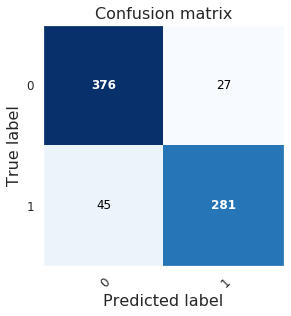

In [0]:
# Plot non-normalized confusion matrix
ax = plot_confusion_matrix(
    df_news[df_news["train"] == False]["fake"], y_test_pred, 
                           classes=np.array([0,1]),
                           title='Confusion matrix',
                           size=5)

Normalized confusion matrix
[[0.93300248 0.06699752]
 [0.13803681 0.86196319]]


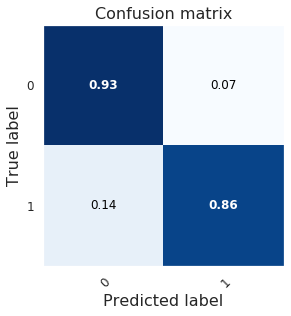

In [18]:
# Plot non-normalized confusion matrix
ax = plot_confusion_matrix(df_news[df_news["train"] == False]["fake"], 
                           y_test_pred, 
                           classes=np.array([0,1]), normalize=True,
                           title='Confusion matrix', size=5)

In [19]:
df_news.head()

,url,source,author,title,theme,description,date_published,body,fake,text,train,nb_words,fake_pred,fp,fn,fake_pred_logreg,fp_logreg,fn_logreg
1,https://www.liberation.fr/france/2019/12/15/le...,Liberation,Nathalie Raulin,Les chefs de service hospitaliers en appellent...,france,Jugeant très insuffisante la réponse du gouver...,15/12/2019,C’est une menace d’une démission collective qu...,0,Les chefs de service hospitaliers en appellent...,False,789,0,False,False,0,False,False
2,https://www.futura-sciences.com/sante/actualit...,Futura Sciences,Futura avec Relaxnews,L'origine des comportements alimentaires ident...,sante,D'après une étude publiée dans la revue,16/12/2019,D'après une étude publiée dans la revue Natur...,0,L'origine des comportements alimentaires ident...,True,499,0,False,False,0,False,False
3,https://www.futura-sciences.com/tech/actualite...,Futura Sciences,Louis Neveu,Microsoft alerte sur de nouvelles techniques d...,tech,Le géant de l'informatique Microsoft vient de ...,16/12/2019,Le géant de l'informatique Microsoft vient de ...,0,Microsoft alerte sur de nouvelles techniques d...,True,412,0,False,False,0,False,False
4,https://www.futura-sciences.com/sciences/actua...,Futura Sciences,Rémy Decourt,L'Europe se dote d'une infrastructure de téléc...,sciences,Pour garantir la sécurité de la libre circulat...,16/12/2019,Pour garantir la sécurité de la libre circulat...,0,L'Europe se dote d'une infrastructure de téléc...,False,1269,0,False,False,0,False,False
6,https://www.futura-sciences.com/sciences/actua...,Futura Sciences,Nathalie Mayer,Science décalée : la créature la plus rapide s...,sciences,Le guépard est l'animal le plus rapide... sur ...,15/12/2019,Le guépard est l'animal le plus rapide... sur ...,0,Science décalée : la créature la plus rapide s...,True,557,0,False,False,0,False,False


#### By newspapers

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide


Normalized confusion matrix
[[0.98019802 0.01980198]
 [       nan        nan]]
Normalized confusion matrix
[[0.98019802 0.01980198]
 [       nan        nan]]
Normalized confusion matrix
[[0.94252874 0.05747126]
 [       nan        nan]]
Normalized confusion matrix
[[0.94252874 0.05747126]
 [       nan        nan]]
Normalized confusion matrix
[[1.]]
Normalized confusion matrix
[[1.]]
Normalized confusion matrix
[[1.]]
Normalized confusion matrix
[[1.]]
Normalized confusion matrix
[[0.89010989 0.10989011]
 [       nan        nan]]
Normalized confusion matrix
[[0.89010989 0.10989011]
 [       nan        nan]]
Normalized confusion matrix
[[       nan        nan]
 [0.14795918 0.85204082]]
Normalized confusion matrix
[[       nan        nan]
 [0.14795918 0.85204082]]
Normalized confusion matrix
[[       nan        nan]
 [0.13043478 0.86956522]]
Normalized confusion matrix
[[       nan        nan]
 [0.13043478 0.86956522]]
Normalized confusion matrix
[[      nan       nan]
 [0.1147541 0.88524

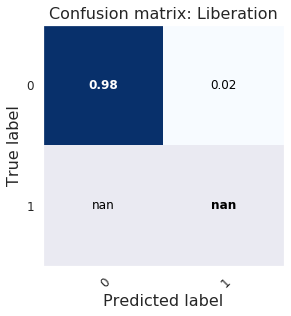

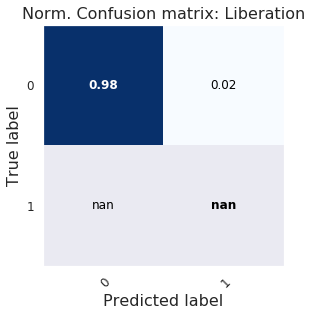

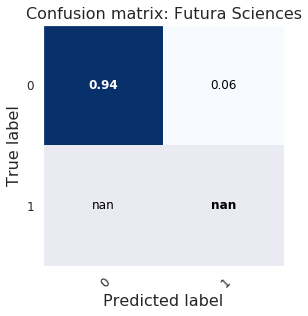

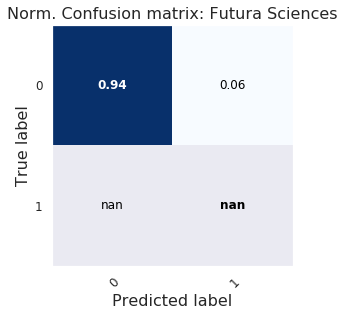

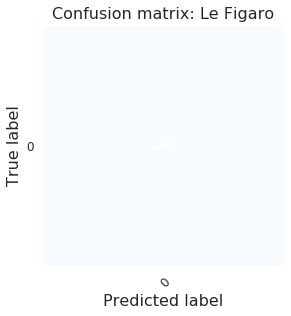

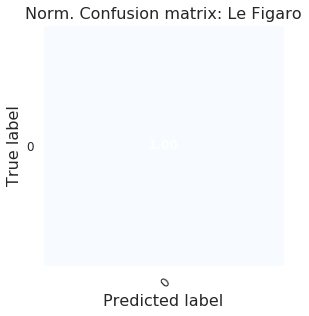

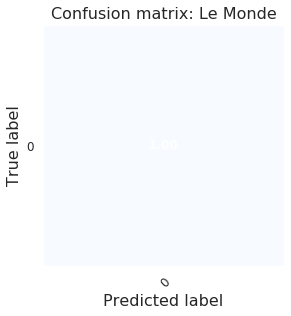

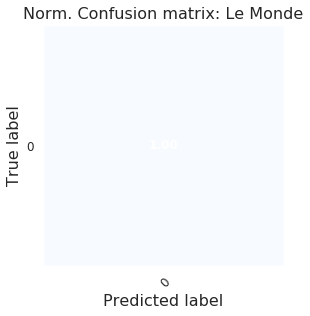

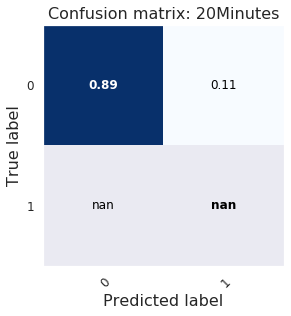

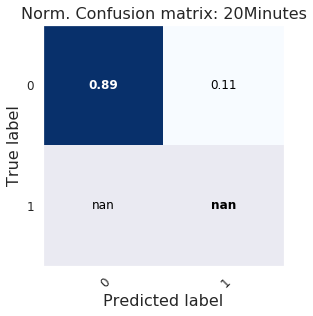

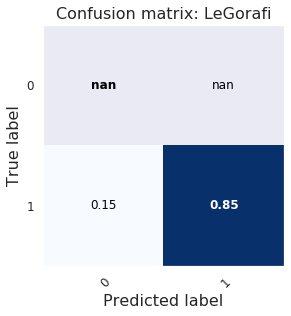

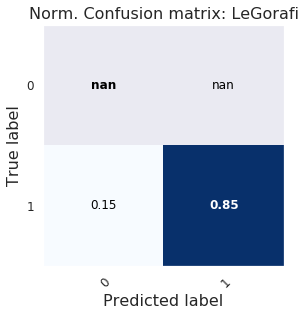

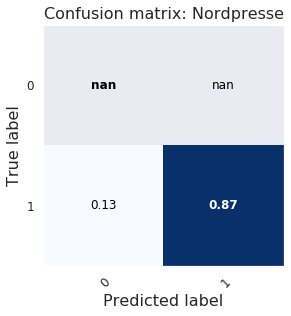

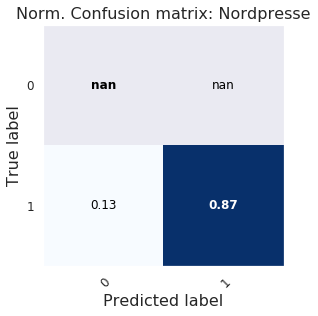

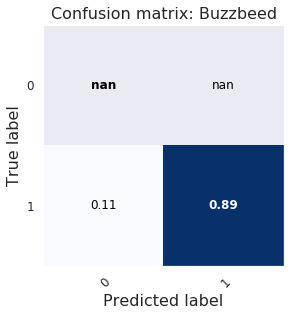

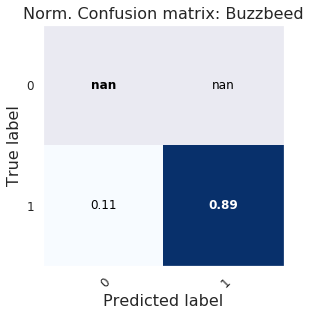

In [26]:
# Plot  confusion matrix

list_ax =[]
for I, newspaper_curr in enumerate(df_news["source"].unique()):
  indices = (df_news["train"] == False) & (df_news["source"] == newspaper_curr)
  
  list_ax.append(plot_confusion_matrix(df_news[indices]["fake"], 
                           df_news[indices]["fake_pred_logreg"], 
                           classes=np.array([0,1]), normalize=True,
                           title='Confusion matrix: '+  newspaper_curr, size=5))
  
  list_ax.append(plot_confusion_matrix(df_news[indices]["fake"], 
                           df_news[indices]["fake_pred_logreg"], 
                           classes=np.array([0,1]), normalize=True,
                           title='Norm. Confusion matrix: ' +  newspaper_curr, 
                           size=5))

#### False Positives : False Fake News

In [0]:
df_news["fp_logreg"] = (df_news["fake"] == 0)&(df_news["fake_pred_logreg"] == 1)

In [0]:
df_news[df_news["fp_logreg"] == True]

,url,source,author,title,theme,description,date_published,body,fake,text,train,nb_words,fake_pred,fp,fn,fake_pred_logreg,fp_logreg
106,https://www.futura-sciences.com/tech/actualite...,Futura Sciences,Fabrice Auclert,L’iPhone 11 Pro collecte des données de géoloc...,tech,Parce qu'il intègre une nouvelle puce dédiée a...,06/12/2019,Parce qu'il intègre une nouvelle puce dédiée a...,0,L’iPhone 11 Pro collecte des données de géoloc...,True,716,0,False,False,1,True
119,https://www.liberation.fr/chroniques/2019/11/2...,Liberation,Mathieu Lindon,"Femmes, le grand remplacement",chroniques,La condition féminine se rebiffe. Cela annonce...,29/11/2019,"Si j’ai bien compris, le mâle hétérosexuel occ...",0,"Femmes, le grand remplacement Si j’ai bien com...",True,571,0,False,False,1,True
126,https://www.liberation.fr/chroniques/2019/11/0...,Liberation,Mathieu Lindon,"Tourisme, pour ou contre ?",chroniques,"Bienvenue aux vrais touristes, ceux qu’on reco...",08/11/2019,"Si j’ai bien compris, il y a une criminalisati...",0,"Tourisme, pour ou contre ? Si j’ai bien compri...",True,620,0,False,False,1,True
226,https://www.futura-sciences.com/maison/actuali...,Futura Sciences,Fabrice Auclert,Ikea lance son premier meuble 4 en 1 robotisé,maison,Le géant suédois du mobilier s'associe à une s...,05/06/2019,Le géant suédois du mobilier s'associe à une s...,0,Ikea lance son premier meuble 4 en 1 robotisé ...,False,389,0,False,False,1,True
331,https://www.futura-sciences.com/sciences/actua...,Futura Sciences,Nathalie Mayer,Mathématiques : le problème des trois cubes a ...,sciences,Décomposer un nombre en la somme de trois cube...,15/09/2019,Décomposer un nombre en la somme de trois cube...,0,Mathématiques : le problème des trois cubes a ...,False,368,0,False,False,1,True
487,https://www.futura-sciences.com/sciences/actua...,Futura Sciences,Rémy Decourt,L’artiste français Jisbar a envoyé sa Joconde ...,sciences,"Le 11 décembre, l'artiste néo pop français Jis...",19/12/2019,"Le 11 décembre, l'artiste néo pop français Jis...",0,L’artiste français Jisbar a envoyé sa Joconde ...,False,459,0,False,False,1,True
594,https://www.liberation.fr/debats/2019/12/20/or...,Liberation,Tania De Montaigne,Orgasme de Noël,debats,,20/12/2019,"Entre 2 manifs, 3 covoiturages et la découvert...",0,"Orgasme de Noël Entre 2 manifs, 3 covoiturages...",False,739,0,False,False,1,True
675,https://www.liberation.fr/planete/2019/12/23/j...,Liberation,Guillaume Gendron,"Jésus, un Palestinien comme les autres à Ramallah",planete,"Chaque mardi, instantanés d’Israël et de Pales...",23/12/2019,Sur la place de la mairie de Ramallah trône un...,0,"Jésus, un Palestinien comme les autres à Ramal...",False,482,0,False,False,1,True
730,https://www.futura-sciences.com/tech/actualite...,Futura Sciences,Fabrice Auclert,Apple veut connecter les iPhone par satellite,tech,Apple se donne cinq ans pour se passer des rés...,24/12/2019,Apple se donne cinq ans pour se passer des rés...,0,Apple veut connecter les iPhone par satellite ...,False,350,0,False,False,1,True
755,https://www.futura-sciences.com/sante/actualit...,Futura Sciences,Marie-Céline Ray,Science décalée : les hommes mangent plus pour...,sante,Une étude de 2015 a montré que les hommes mang...,28/12/2019,Une étude de 2015 a montré que les hommes mang...,0,Science décalée : les hommes mangent plus pour...,False,527,0,False,False,1,True


In [0]:
# count all news by sources
s_source = df_news.source.value_counts(sort=False)
# count false positives by sources
s_source_fp = \
  df_news[df_news["fp_logreg"] == True].source.value_counts(sort=False)
# label True news sources
list_true_sources = df_news[df_news["fake"] == 0]["source"].unique()
# calculate repartition of false positive by sources
s_pc_fp = s_source.filter(items=list_true_sources).astype('float')
for source_name in s_pc_fp.index:
  if source_name in s_source_fp.index.tolist():
    print("{} / {}".format(s_source_fp[source_name], s_pc_fp[source_name]))
    s_pc_fp[source_name] = 100*s_source_fp[source_name]/s_pc_fp[source_name]
  else:
    s_pc_fp[source_name] = 0

s_pc_fp

5 / 333.0
6 / 317.0
32 / 585.0


Liberation         1.501502
Futura Sciences    1.892744
Le Figaro          0.000000
Le Monde           0.000000
20Minutes          5.470085
Name: source, dtype: float64

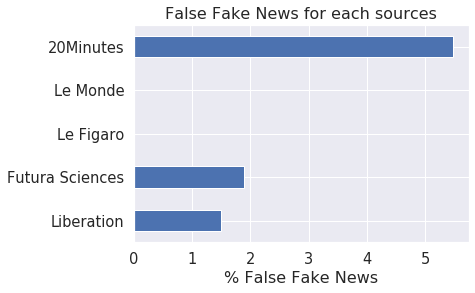

In [0]:
ax = s_pc_fp.plot.barh()
ax.set_title("False Fake News for each sources")
ax.set_xlabel("% False Fake News");

In [0]:
# count all news by themes
s_theme = df_news["theme"].value_counts(sort=False)
# count false positives by themes
s_theme_fp = \
  df_news[df_news["fp_logreg"] == True].theme.value_counts(sort=False)
# label True news themes
list_true_themes = df_news[df_news["fake"] == 0]["theme"].unique()
# calculate repartition of false positive by sources
s_pc_fp = s_theme.filter(items=list_true_themes).astype('float')
for theme_name in s_pc_fp.index:
  if theme_name in s_theme_fp.index.tolist():
    print("{} / {}".format(s_theme_fp[theme_name], s_pc_fp[theme_name]))
    s_pc_fp[theme_name] = 100*s_theme_fp[theme_name]/s_pc_fp[theme_name]
  else:
    s_pc_fp[theme_name] = 0
s_pc_fp

1 / 282.0
1 / 44.0
2 / 105.0
2 / 221.0
1 / 201.0
1 / 31.0
2 / 12.0
1 / 20.0
11 / 605.0
21 / 523.0


france              0.354610
sante               2.272727
tech                1.904762
sciences            0.904977
planete             0.497512
debats              3.225806
sports              0.000000
chroniques         16.666667
article             0.000000
maison              5.000000
actu conseils       0.000000
economie            0.000000
politique           1.818182
evenements libe     0.000000
culture             0.000000
monde               0.000000
m perso             0.000000
societe             4.015296
idees               0.000000
m le mag            0.000000
police justice      0.000000
Name: theme, dtype: float64

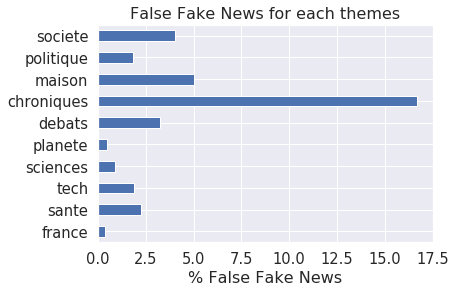

In [0]:
#fig = plt.figure(figsize=(8, 8))
ax = s_pc_fp[s_pc_fp.values>0].plot.barh()
ax.set_title("False Fake News for each themes")
ax.set_xlabel("% False Fake News");

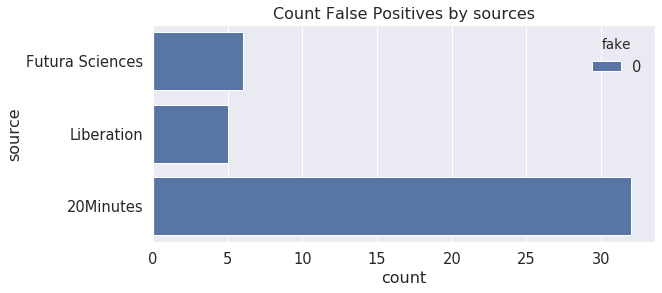

In [0]:
# Categorical bar plot with train/test
fig = plt.figure(figsize=(9, 4))
plt.title("Count False Positives by sources")
ax = sns.countplot(y="source", hue="fake", 
              data=df_news[df_news["fp_logreg"] == True])

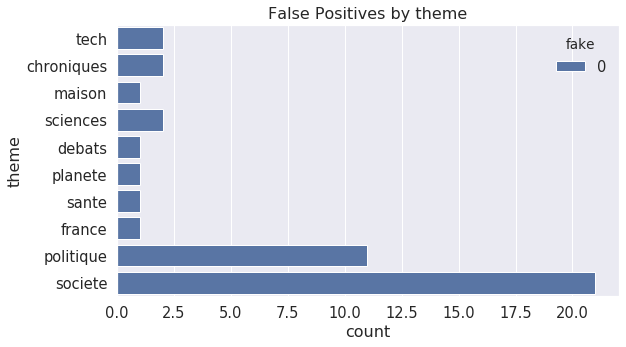

In [0]:
# Categorical bar plot with train/test
fig = plt.figure(figsize=(9, 5))
plt.title("False Positives by theme")
ax = sns.countplot(y="theme", hue="fake", 
              data=df_news[df_news["fp_logreg"] == True])

#### False Negatives : False True News

In [0]:
df_news["fn_logreg"] = (df_news["fake"] == 1)&(df_news["fake_pred_logreg"] == 0)
df_news[df_news["fn_logreg"] == True]

,url,source,author,title,theme,description,date_published,body,fake,text,train,nb_words,fake_pred,fp,fn,fake_pred_logreg,fp_logreg,fn_logreg
1469,http://www.legorafi.fr/2019/12/03/bayer-monsan...,LeGorafi,La Rédaction,Bayer Monsanto rachète le stock d’armes chimiq...,societe,La société spécialisée dans la chimie et l’ali...,03/12/2019,Le président de la firme américaine Hugh Grant...,1,Bayer Monsanto rachète le stock d’armes chimiq...,True,273,1,False,False,0,False,True
1489,http://www.legorafi.fr/2019/10/02/a-t-on-le-dr...,LeGorafi,La Rédaction,A-t-on le droit de se masturber un jour de deu...,societe,Suite à l’hommage national rendu à l’ancien ch...,02/10/2019,Après une étude peu approfondie de la constitu...,1,A-t-on le droit de se masturber un jour de deu...,True,192,1,False,False,0,False,True
1490,http://www.legorafi.fr/2019/09/23/la-correze-s...,LeGorafi,La Rédaction,La Corrèze soupçonnée dans l’attaque de drone ...,societe,Le centre de la France ne n’a jamais été aussi...,23/09/2019,"Dans la nuit du jeudi 19 février, les autorité...",1,La Corrèze soupçonnée dans l’attaque de drone ...,False,180,1,False,False,0,False,True
1499,http://www.legorafi.fr/2019/09/09/surpopulatio...,LeGorafi,La Rédaction,Surpopulation carcérale : les rats toujours pl...,societe,La situation des prisons en France ne s’amélio...,09/09/2019,"Ronger le même oreiller, partager son repas av...",1,Surpopulation carcérale : les rats toujours pl...,False,163,1,False,False,0,False,True
1517,http://www.legorafi.fr/2019/08/15/napoleon-aur...,LeGorafi,La Rédaction,Napoléon aurait eu 250 ans aujourd’hui,societe,"En effet, les experts sont unanimes sur ce poi...",15/08/2019,"Le 15 août 1769, Napoléon Bonaparte venait au ...",1,Napoléon aurait eu 250 ans aujourd’hui Le 15 a...,False,109,1,False,False,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393,https://www.buzzbeed.com/radars-marins-mobiles...,Buzzbeed,Francis Lépante,Des radars sous-marins mobiles installés près ...,Insolite,NaN,2017-04-10,A l’heure où les gens font n’importe quoi ave...,1,Des radars sous-marins mobiles installés près ...,False,222,1,False,False,0,False,True
2425,https://www.buzzbeed.com/cours-de-francais-de-...,Buzzbeed,Jean Deumerez,Les cours de Français et de mathématiques en o...,politique,NaN,2017-03-24,Le gouvernement est bien décidé à poursuivre ...,1,Les cours de Français et de mathématiques en o...,False,388,1,False,False,0,False,True
2470,https://www.buzzbeed.com/une-nouvelle-attaque-...,Buzzbeed,Francis Lépante,Une nouvelle attaque au gaz irritant à Hambour...,Insolite,NaN,2017-03-11,"Le trafic de métro a été suspendu à Hambourg,...",1,Une nouvelle attaque au gaz irritant à Hambour...,False,174,1,False,False,0,False,True
2503,https://www.buzzbeed.com/lancement-dune-campag...,Buzzbeed,Francis Lépante,Lancement d’une campagne nationale de préventi...,Vivre ensemble,NaN,2017-03-04,Alors qu’une grande campagne nationale est la...,1,Lancement d’une campagne nationale de préventi...,False,156,0,False,True,0,False,True


In [0]:
# count all news by sources
s_source = df_news.source.value_counts(sort=False)
# count false negatives by sources
s_source_fn = df_news[df_news["fn_logreg"] == True].source.value_counts(sort=False)
# label Fake news sources
list_fake_sources = df_news[df_news["fake"] == 1]["source"].unique()
# calculate repartition of false positive by sources
s_pc_fn = s_source.filter(items=list_fake_sources).astype('float')
for source_name in s_pc_fn.index:
  if source_name in s_source_fn.index.tolist():
    print("{} / {}".format(s_source_fn[source_name], s_pc_fn[source_name]))
    s_pc_fn[source_name] = 100*s_source_fn[source_name]/s_pc_fn[source_name]
  else:
    s_pc_fn[source_name] = 0
s_pc_fn

40 / 621.0
16 / 210.0
10 / 240.0


LeGorafi      6.441224
Nordpresse    7.619048
Buzzbeed      4.166667
Name: source, dtype: float64

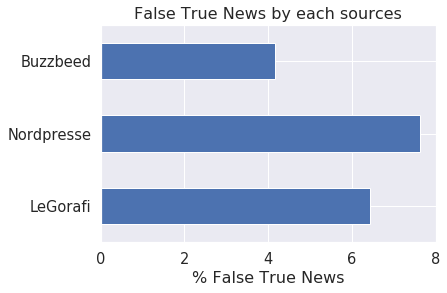

In [0]:
ax = s_pc_fn.plot.barh()
ax.set_title("False True News by each sources")
ax.set_xlabel("% False True News");

In [0]:
# count all news by themes
s_theme = df_news["theme"].value_counts(sort=False)
# count false neg by themes
s_theme_fn = df_news[df_news["fn_logreg"] == True].theme.value_counts(sort=False)
# label True news themes
list_fake_themes = df_news[df_news["fake"] == 1]["theme"].unique()
# calculate repartition of false positive by sources
s_pc_fn = s_theme.filter(items=list_fake_themes).astype('float')
for theme_name in s_pc_fn.index:
  if theme_name in s_theme_fn.index.tolist():
    print("{} / {}".format(s_theme_fn[theme_name], s_pc_fn[theme_name]))
    s_pc_fn[theme_name] = 100*s_theme_fn[theme_name]/s_pc_fn[theme_name]
  else:
    s_pc_fn[theme_name] = 0
s_pc_fn

13 / 523.0
10 / 605.0
8 / 282.0
1 / 35.0
16 / 221.0
6 / 105.0
1 / 20.0
1 / 1.0
1 / 5.0
1 / 1.0
1 / 27.0
2 / 36.0
1 / 33.0
1 / 29.0
2 / 38.0
1 / 2.0


societe                     2.485660
politique                   1.652893
france                      2.836879
economie                    2.857143
sciences                    7.239819
Culture                     0.000000
tech                        5.714286
Gilets Jaunes               5.000000
Start Up Nation           100.000000
monde                       0.000000
Violence                    0.000000
sports                      0.000000
Religion                   20.000000
medias                    100.000000
People                      0.000000
non classe                  3.703704
Honteux                     0.000000
sante                       0.000000
Justice                     0.000000
Sexe                        0.000000
Insolite                    5.555556
Sentiment d'insécurité      3.030303
planete                     0.000000
Justice sociale             3.448276
Vivre ensemble              5.263158
Fait divers                 0.000000
Fake news                  50.000000
N

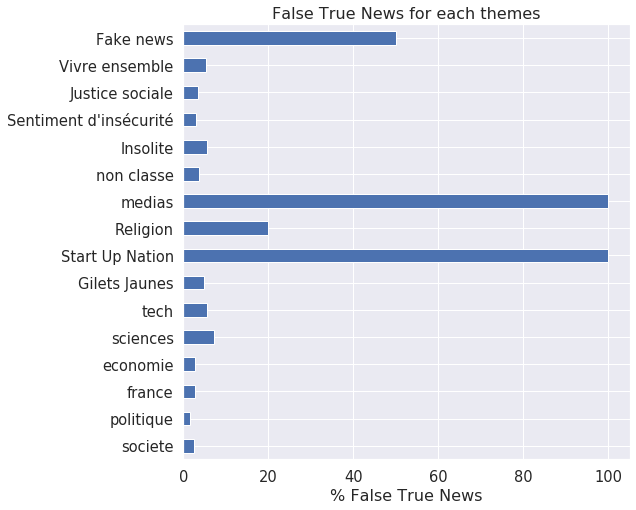

In [0]:
fig = plt.figure(figsize=(8, 8))
ax = s_pc_fn[s_pc_fn.values>0].plot.barh()
ax.set_title("False True News for each themes")
ax.set_xlabel("% False True News");

In [0]:
# save results into dataFrame
joblib.dump(df_news, PATH_DF_NEWS_SAVE)

['/content/drive/My Drive/OpenClassRooms/IML_Projet_7/data/df_news.pkl']

## Cross-validation

In [0]:
# Split parameters
n_splits = 5
test_size = 0.3

# preparation des splits : choix de splits aléatoires de meme taille
cv_fake = model_selection.StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, 
                                  random_state=RANDOM_STATE)

In [0]:
clf_log_reg_cv = LogisticRegression(random_state=RANDOM_STATE)
scores = cross_val_score(clf_log_reg_cv, X_train_tfidf, 
                         df_news_clean[df_news_clean["train"] == True]["fake"], 
                         cv=cv_fake)

In [20]:
scores

array([0.88062622, 0.89041096, 0.8962818 , 0.87671233, 0.89236791])

In [21]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), 
                                        1.96*scores.std()/(n_splits)**0.5))

Accuracy: 0.89 (+/- 0.01)


In [22]:
df_res.at["RegLog","mean_acc_test_splits"] = scores.mean()
df_res.at["RegLog","error_margin"] = 1.96*scores.std()/(n_splits)**0.5
df_res

,acc_train,acc_test,mean_acc_test_splits,error_margin
camemBERT,1.000000,0.964335,0.981996,0.004900
RegLog,0.978274,0.901235,0.887280,0.006473


In [23]:
try:
  df_res_disk = joblib.load(PATH_DF_RES_SAVE)
  #df_res_in = df_res.copy()
  try:
    df_res_disk.loc["RegLog"] = df_res.loc["RegLog"]
    df_res = df_res_disk.copy()
  except:
    df_res_disk.append(df_res)
    df_res = df_res_disk.copy()
except:
  df_res_disk = None
joblib.dump(df_res, PATH_DF_RES_SAVE) 

['../../data/df_res.pkl']

## Compare with camemBERT

#### Load results

In [0]:
df_res = joblib.load(PATH_DF_RES_SAVE)

#### Plot

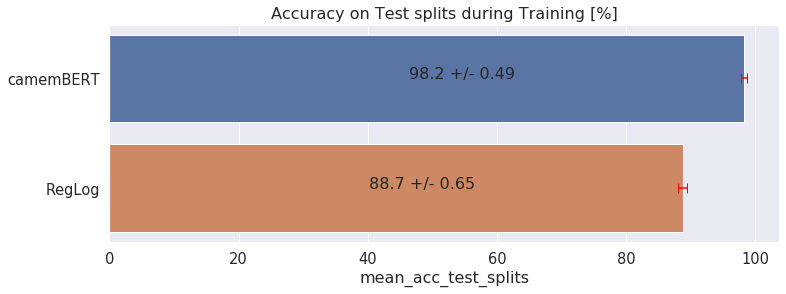

In [5]:
fig = plt.figure(figsize=(12, 4))
plt.title("Accuracy on Test splits during Training [%]")
ax = sns.barplot(
    y=df_res.index,
    x=100*df_res["mean_acc_test_splits"], orient="h")

plt.errorbar(x=100*df_res["mean_acc_test_splits"],
    y=df_res.index,
    xerr=100*df_res["error_margin"],
    fmt='none', errorevery=1, alpha=1,
    ecolor="red", capsize=5);

for I, index in enumerate(df_res.index):

  plt.text(x=100*df_res.at[index,"acc_test"]-50, y=I,
      s= '{:.1f} +/- {:.2f}'.format(100*df_res.at[index,"mean_acc_test_splits"],
                                       100*df_res.at[index,"error_margin"]), 
           fontsize=16)

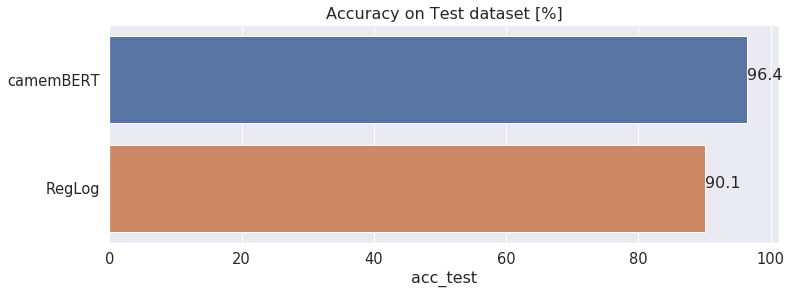

In [60]:
fig = plt.figure(figsize=(12, 4))
plt.title("Accuracy on Test dataset [%]")
ax = sns.barplot(
    y=df_res.index,
    x=100*df_res["acc_test"], orient="h")

for I, index in enumerate(df_res.index):
  plt.text(x=100*df_res.at[index,"acc_test"], y=I,
         s= '{:.1f}'.format(100*df_res.at[index,"acc_test"]), fontsize=16)

## Export data news in .CSV with code

In [7]:
pwd

'/content/drive/My Drive/OpenClassRooms/IML_Projet_7/code/FakeNewsDetectionFr'

In [0]:
if os.path.isdir(PATH_FOLDER_EXPORT) == False:
    os.mkdir(PATH_FOLDER_EXPORT)
df_news.index.name = "news"
df_news.to_csv(PATH_DF_NEWS_EXPORT)

### Check by reload from CSV

In [15]:
df_news_csv = pd.read_csv(PATH_DF_NEWS_EXPORT, index_col='news')
df_news_csv.head()

,url,source,author,title,theme,description,date_published,body,fake,text,train,nb_words,fake_pred,fp,fn,fake_pred_logreg,fp_logreg,fn_logreg
news,,,,,,,,,,,,,,,,,,
1,https://www.liberation.fr/france/2019/12/15/le...,Liberation,Nathalie Raulin,Les chefs de service hospitaliers en appellent...,france,Jugeant très insuffisante la réponse du gouver...,15/12/2019,C’est une menace d’une démission collective qu...,0,Les chefs de service hospitaliers en appellent...,False,789,0,False,False,0,False,False
2,https://www.futura-sciences.com/sante/actualit...,Futura Sciences,Futura avec Relaxnews,L'origine des comportements alimentaires ident...,sante,D'après une étude publiée dans la revue,16/12/2019,D'après une étude publiée dans la revue Natur...,0,L'origine des comportements alimentaires ident...,True,499,0,False,False,0,False,False
3,https://www.futura-sciences.com/tech/actualite...,Futura Sciences,Louis Neveu,Microsoft alerte sur de nouvelles techniques d...,tech,Le géant de l'informatique Microsoft vient de ...,16/12/2019,Le géant de l'informatique Microsoft vient de ...,0,Microsoft alerte sur de nouvelles techniques d...,True,412,0,False,False,0,False,False
4,https://www.futura-sciences.com/sciences/actua...,Futura Sciences,Rémy Decourt,L'Europe se dote d'une infrastructure de téléc...,sciences,Pour garantir la sécurité de la libre circulat...,16/12/2019,Pour garantir la sécurité de la libre circulat...,0,L'Europe se dote d'une infrastructure de téléc...,False,1269,0,False,False,0,False,False
6,https://www.futura-sciences.com/sciences/actua...,Futura Sciences,Nathalie Mayer,Science décalée : la créature la plus rapide s...,sciences,Le guépard est l'animal le plus rapide... sur ...,15/12/2019,Le guépard est l'animal le plus rapide... sur ...,0,Science décalée : la créature la plus rapide s...,True,557,0,False,False,0,False,False
